# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from natsort import natsorted
from tqdm import tqdm

Checking if GPU is being detected

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Reading the Data

Download dataset from - https://learner.csie.ntu.edu.tw/~boyochen/TCIR/TCIR-ALL_2017.h5.tar.gz

In [3]:
data_info = pd.read_hdf('./TCIR-ALL_2017/TCIR-ALL_2017.h5', key="info", mode='r')

In [4]:
data_info

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017122600,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017122603,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017122606,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017122609,18.0,0.0,1009.0


In [5]:
with h5py.File('./TCIR-ALL_2017/TCIR-ALL_2017.h5', 'r') as hf:
    data_matrix = hf['matrix'][:]

In [6]:
data_matrix.shape

(4580, 201, 201, 4)

In [7]:
type(data_matrix)

numpy.ndarray

In [8]:
# print(data_matrix[0])

In [9]:
# Setting parameters for plotting images
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

In [10]:
data_info.shape

(4580, 8)

In [11]:
data_info.describe()

,lon,lat,Vmax,R35_4qAVG,MSLP
count,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,24.180524,12.804520,48.135590,55.530131,990.660480
std,109.456404,17.717385,26.292319,59.074171,18.650596
min,-147.900000,-35.800000,15.000000,0.000000,909.000000
25%,-88.125000,9.100000,30.000000,0.000000,982.000000
50%,56.600000,16.700000,40.000000,43.800000,996.000000
75%,123.525000,24.500000,60.000000,92.500000,1004.000000
max,204.900000,60.100000,155.000000,406.200000,1017.000000


Separating the 4 channels (Infrared, Water Vapour, Visibile, Microwave)

In [12]:
df_ir = data_matrix[:, :, :, 0]
df_wv = data_matrix[:, :, :, 1]
df_vis = data_matrix[:, :, :, 2]
df_mcw = data_matrix[:, :, :, 3]
# for image in tqdm(data_matrix):
#     ir, wv, vis, mcw = image[:, :, 0], image[:, :, 1], image[:, :, 2], image[:, :, 3]
    
#     df_ir.append(ir)
#     df_wv.append(wv)
#     df_vis.append(vis)
#     df_mcw.append(mcw)

# # only_2_chan = np.array(only_2_chan)
# df_ir = np.array(df_ir)
# df_wv = np.array(df_wv)
# df_vis = np.array(df_vis)
# df_mcw = np.array(df_mcw)

In [13]:
del data_matrix

In [14]:
df_ir.shape

(4580, 201, 201)

Selecting only 2 channels: Infrared and Microwave as visible is extremely unstable and Water Vapour is very similar to IR

In [15]:
only_2_chan = np.stack((df_ir, df_mcw), axis=1)
print(only_2_chan.shape)

(4580, 2, 201, 201)


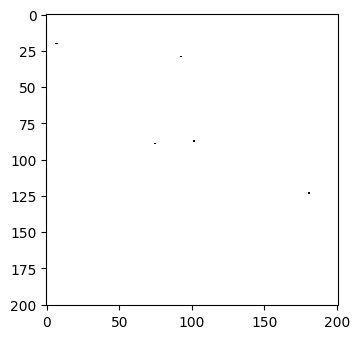

In [17]:
plt.imshow(df_vis[0], cmap='gray')
plt.show()

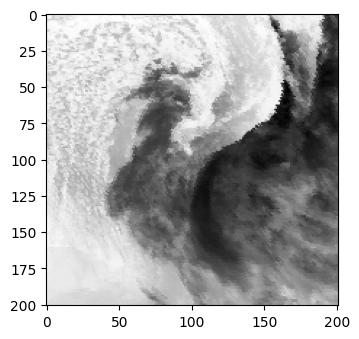

In [16]:
plt.imshow(df_ir[0], cmap='gray')
plt.show()

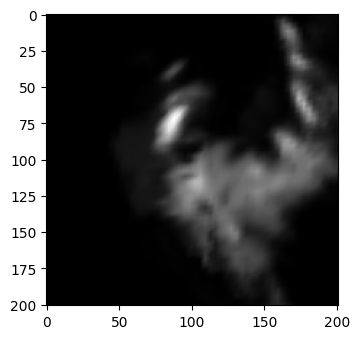

In [17]:

plt.imshow(only_2_chan[0][1], cmap='gray')
plt.show()

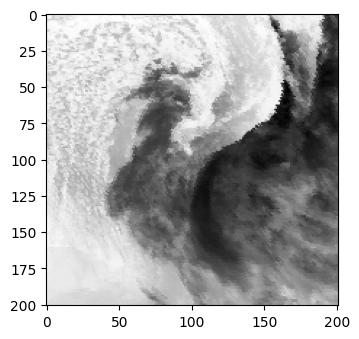

In [18]:
plt.imshow(only_2_chan[0][0], cmap='gray')
plt.show()

# Preprocessing

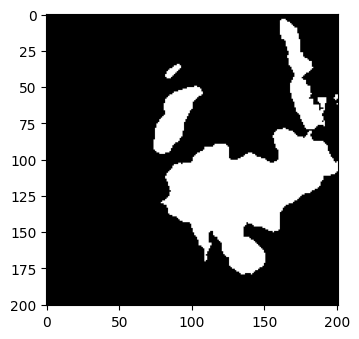

In [18]:
otsu_threshold, image_result = cv2.threshold(df_mcw[0].astype("uint8"), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(image_result, cmap='gray')
plt.show()

In [19]:
del df_mcw, df_ir, df_vis, df_wv

getting preprocessed images

In [20]:
df_preprocessed = []
i=0
count = 0
for image in tqdm(only_2_chan):
    
    # median blur noise removal
    # image_result = cv2.medianBlur(image_result, 5)
    
    # # opening
    # kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    # image_result = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel_open)

    # # erosion
    # kernel_erode = cv2.getStructuringElement(cv2.MORPH_ERODE, (5, 5))
    # erosion = cv2.erode(image_result, kernel_erode)

    # # image_result = cv2.subtract(image_result, erosion)
    # print(image.shape)


    # We check if there are any nan values in the images. If there are, we drop them as there are not many images with
    # nans
    mask1 = (image[0][np.isnan(image[0])])
    mask2 = (image[1][np.isnan(image[1])])
    if len(mask1)==0 and len(mask2) == 0:
        image_result = image
    else:
        # print(i)
        # count += 1
        # print(len(mask)/201)
        # mask = mask.reshape(201, 201,1).astype("uint8")
        
        # plt.imshow(mask, cmap='gray')

        # image_result = cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)
        image_result = image
        data_info.drop(i, axis=0, inplace=True)
        i+=1
        # print("bleh")
        continue
    
    # thresholding
    otsu_threshold, image_result_ir = cv2.threshold(image[0].astype("uint8"), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    otsu_threshold, image_result_mcw = cv2.threshold(image[1].astype("uint8"), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    image_result = np.stack((image_result_ir, image_result_mcw))
    # print(image_result.shape)

    # plt.imshow(image_result[0], cmap='gray')
    # plt.imshow(erosion, cmap='gray')
    df_preprocessed.append(image_result)


    # plt.show()

    # cv2.imwrite("./preprocessed/2chans/" + str(i) + ".png", image_result)
    i+=1

df_preprocessed = np.array(df_preprocessed)
data_info.reset_index(inplace=True)
print(count)

100%|██████████| 4580/4580 [00:01<00:00, 4511.47it/s]


0


Reshaping the images into a (N, N, Channel) format

In [21]:
df_ir_preprocessed = []
df_mcw_preprocessed = []
for image in tqdm(df_preprocessed):
    df_ir_preprocessed.append(image[0])
    df_mcw_preprocessed.append(image[1])
df_ir_preprocessed = np.array(df_ir_preprocessed)
df_mcw_preprocessed = np.array(df_mcw_preprocessed)

df_new = np.stack((df_ir_preprocessed, df_mcw_preprocessed), axis=-1)

100%|██████████| 4560/4560 [00:00<00:00, 1012387.58it/s]


In [22]:
del df_ir_preprocessed, df_mcw_preprocessed, df_preprocessed

# Creating the Model

In [23]:
model = Sequential()
model.add(layers.Conv2D(16, (3, 3), input_shape=(201, 201, 2)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanSquaredError()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 16)      304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

# Splitting the data into train, test and validation set
(The train_test_split method was not used as there was some error in the python environment)

In [24]:
X, X_test, y, y_test = train_test_split(df_new, data_info['Vmax'], test_size=0.1, shuffle=True)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [26]:
X_train.shape

(3283, 201, 201, 2)

In [27]:
X_val.shape

(821, 201, 201, 2)

In [28]:
X_test.shape

(456, 201, 201, 2)

In [66]:
choice = np.random.choice(a=[False, True], size=(len(data_info), 1), p=[0.3, 0.7]).reshape(-1) 

In [67]:
train_x = np.array([df_new[i] for i in range(len(data_info)) if choice[i]])
train_y = np.array([data_info.loc[i, 'Vmax'] for i in range(len(data_info)) if choice[i]])
temp_x = np.array([df_new[i] for i in range(len(data_info)) if choice[i] == False])
temp_y = np.array([data_info.loc[i, 'Vmax'] for i in range(len(data_info)) if choice[i] == False])

In [68]:
choice_temp = np.random.choice(a=[False, True], size=(len(temp_x), 1), p=[0.65, 0.35]).reshape(-1)

In [69]:
test_x = np.array([temp_x[i] for i in range(len(temp_x)) if choice_temp[i]])
test_y = np.array([temp_y[i] for i in range(len(temp_x)) if choice_temp[i]])

val_x = np.array([temp_x[i] for i in range(len(temp_x)) if choice_temp[i] == False])
val_y = np.array([temp_y[i] for i in range(len(temp_x)) if choice_temp[i] == False])

Defining early stopping callback so that the given function does not overfit the training data

In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Training

In [71]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[callback], batch_size=256)

Epoch 1/100
13/13 [==============================] - 4s 184ms/step - loss: 2982.4709 - mean_squared_error: 2982.4709 - val_loss: 555.6633 - val_mean_squared_error: 555.6633
Epoch 2/100
13/13 [==============================] - 1s 96ms/step - loss: 1020.1003 - mean_squared_error: 1020.1003 - val_loss: 469.3423 - val_mean_squared_error: 469.3423
Epoch 3/100
13/13 [==============================] - 1s 94ms/step - loss: 831.2227 - mean_squared_error: 831.2227 - val_loss: 408.5973 - val_mean_squared_error: 408.5973
Epoch 4/100
13/13 [==============================] - 1s 95ms/step - loss: 681.6533 - mean_squared_error: 681.6533 - val_loss: 365.9888 - val_mean_squared_error: 365.9888
Epoch 5/100
13/13 [==============================] - 1s 95ms/step - loss: 590.8723 - mean_squared_error: 590.8723 - val_loss: 352.1184 - val_mean_squared_error: 352.1184
Epoch 6/100
13/13 [==============================] - 1s 94ms/step - loss: 569.2109 - mean_squared_error: 569.2109 - val_loss: 328.9087 - val_mean

Predictions

In [72]:
predictions = model.predict(test_x)

In [73]:
print(predictions[0:10].reshape(-1))

[34.22856  24.499432 24.214016 24.533089 30.361118 38.842922 34.99885
 35.861843 39.084957 20.608456]


In [74]:
print(test_y[0:10])

[40. 30. 30. 30. 38. 45. 30. 40. 45. 20.]


In [75]:
mse = tf.compat.v1.losses.mean_squared_error(
   labels=test_y,
   predictions=predictions.reshape(-1)).numpy()

In [76]:
mse**0.5

10.469284545004847